In [1]:
%load_ext autoreload
%autoreload 2

In [200]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from networks import AdditiveNoisyNet
from noise_generator import GaussianNoiseGenerator
from noise_transformer import ConstantNoiseTransformer, BlockNoiseTransformer
from data import generate_data
from torch.utils.data import TensorDataset
from train import Trainer

### Studying NoisyNets

In [444]:
X_test = torch.linspace(-5, 5, 1000).unsqueeze(-1)

In [445]:
input_dim = 1
output_dim = 1
n_hidden = 128
hidden_layers = 2
activation_fn = nn.ReLU

In [551]:
size = 20
# mu = torch.zeros(size)
# logsigma = -3 * torch.ones(size)
model = nn.Sequential(nn.Linear(input_dim, n_hidden), activation_fn(),
                              nn.Linear(n_hidden, n_hidden), activation_fn(),
                              nn.Linear(n_hidden, 2 * size))
noise_generator = GaussianNoiseGenerator(size=size, 
                                         # mu=mu,
                                         # logsigma=logsigma, 
                                         model=model, model_out='both')
noise_transformer = ConstantNoiseTransformer(output_dim + n_hidden * hidden_layers)
noise_transformer = BlockNoiseTransformer(output_dim + n_hidden * hidden_layers, B=4)

In [552]:
model = AdditiveNoisyNet(input_dim, n_hidden, hidden_layers, output_dim, activation_fn, noise_generator, noise_transformer)

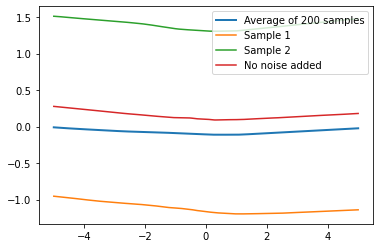

In [553]:
samples = torch.stack([model.sample(X_test, fixed_noise=True).detach().squeeze() for _ in range(20)], 0)
plt.plot(X_test, samples.mean(0), linewidth=2., label='Average of 200 samples')
plt.plot(X_test, samples[0, :], label='Sample 1')
plt.plot(X_test, samples[1, :], label='Sample 2')
plt.plot(X_test, model(X_test, sigma=0.).detach(), label='No noise added')
plt.legend()
plt.show()

In [559]:
z = torch.randn(5, 1)
z2 = torch.randn(5, 1)
(torch.stack([z, z2]) - z).var(0).shape

torch.Size([5, 1])

In [449]:
differences = {}
logsigmas = (-5, -4, -3, -2, -1, 0, 1, 2)
size = 1
hidden_layers = 2
activation_fn = nn.ReLU
mu = torch.zeros(size)
for logs in logsigmas:
    logsigma = logs * torch.ones(size)
    noise_generator = GaussianNoiseGenerator(size=1, mu=mu, logsigma=logsigma)
    noise_transformer = ConstantNoiseTransformer(output_dim + n_hidden * hidden_layers)
    differences[logs] = []
    for _ in range(10):
        model = AdditiveNoisyNet(input_dim, n_hidden, hidden_layers, output_dim, activation_fn, noise_generator, noise_transformer)
        samples = torch.stack([model.sample(X_test, fixed_noise=True).detach().squeeze() for _ in range(20)], 0)
        samples_mean = samples.mean(0)
        noiseless = model(X_test, sigma=0.).detach().squeeze()
        differences[logs].append((noiseless - samples_mean).abs().mean().item())



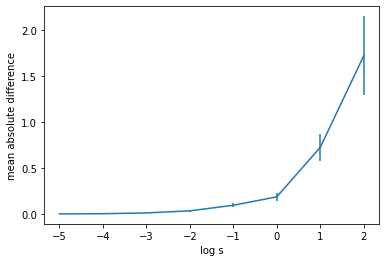

In [450]:
plt.errorbar(logsigmas, [np.mean(differences[logs]) for logs in logsigmas],
             [np.std(differences[logs]) / np.sqrt(10.) for logs in logsigmas])
plt.xlabel(r'log s')
plt.ylabel('mean absolute difference')
plt.show()

## Training noisynets

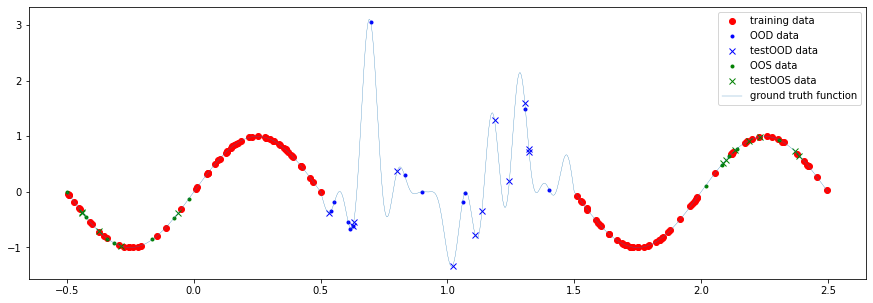

In [338]:
x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test, oos_y_test, ood_x_test, ood_y_test, x_test, y_test = generate_data(plot=True,
                                                                                                                 seed=8)

In [357]:
input_dim = 1
output_dim = 1
n_hidden = 128
hidden_layers = 3
activation_fn = nn.ReLU

lr = 1e-3
batch_size = 64

size = 1
mu = torch.zeros(size)
logsigma = -2 * torch.ones(size)
noise_generator = GaussianNoiseGenerator(size=1, mu=mu, logsigma=logsigma)
noise_transformer = ConstantNoiseTransformer(output_dim + n_hidden * hidden_layers)

model = AdditiveNoisyNet(input_dim, n_hidden, hidden_layers, output_dim, activation_fn, noise_generator, noise_transformer)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_dataset = TensorDataset(x, y)
validation_dataset = TensorDataset(oos_x, oos_y)

trainer = Trainer(model, optimizer, train_dataset, validation_dataset, batch_size)


In [358]:
trainer.train(epochs=500)


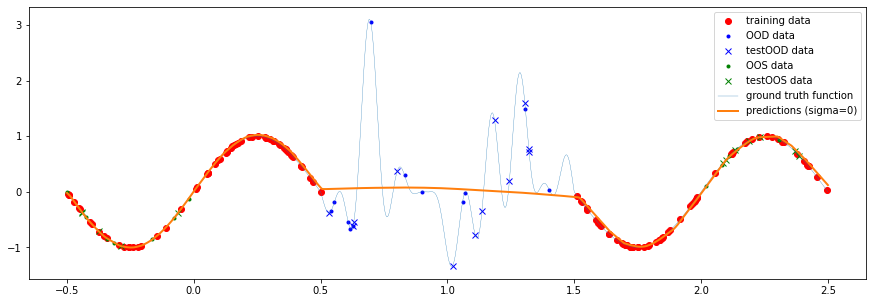

In [359]:
plt.figure(figsize=(15, 5))
plt.plot(x, y.squeeze(), 'ro', label='training data')
plt.plot(ood_x, ood_y.squeeze(), 'b.', label='OOD data')
plt.plot(ood_x_test, ood_y_test.squeeze(), 'bx', label='testOOD data')
plt.plot(oos_x, oos_y.squeeze(), 'g.', label='OOS data')
plt.plot(oos_x_test, oos_y_test.squeeze(), 'gx', label='testOOS data')
plt.plot(x_test, y_test.squeeze(), label='ground truth function', linewidth=.3)
plt.plot(x_test, model(x_test
                       , sigma=0., fixed_noise=True,
                      ).detach(), linewidth=2., label='predictions (sigma=0)')
# plt.plot(x_test, torch.stack([model.sample(x_test, fixed_noise=True).detach().squeeze() for _ in range(15)], 0).mean(0),
#          label='average samples (sigma=1)')
        
plt.legend()


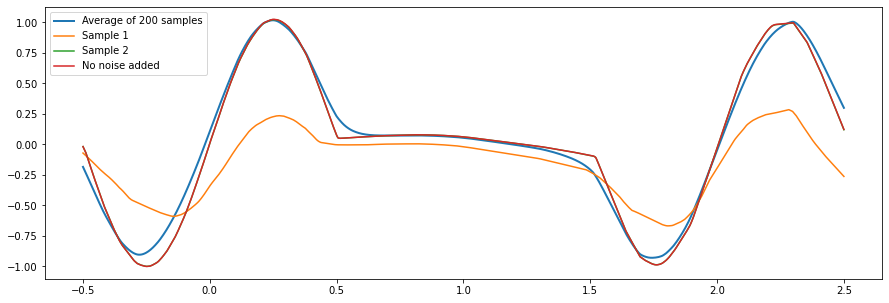

In [372]:
plt.figure(figsize=(15, 5))
samples = torch.stack([model.sample(x_test, fixed_noise=True).detach().squeeze() for _ in range(200)], 0)
plt.plot(x_test, samples.mean(0), linewidth=2., label='Average of 200 samples')
plt.plot(x_test, samples[0, :], label='Sample 1')
plt.plot(x_test, samples[1, :], label='Sample 2')
plt.plot(x_test, model(x_test, sigma=0.).detach(), label='No noise added')
plt.legend()
plt.show()


## Training corrupted NoisyNets

In [438]:
input_dim = 1
output_dim = 1
n_hidden = 128
hidden_layers = 3
activation_fn = nn.ReLU

lr = 1e-3
batch_size = 64

size = 1
mu = torch.zeros(size)
logsigma = -2 * torch.ones(size)
noise_generator = GaussianNoiseGenerator(size=1, mu=mu, logsigma=logsigma)
noise_transformer = ConstantNoiseTransformer(output_dim + n_hidden * hidden_layers)

model = AdditiveNoisyNet(input_dim, n_hidden, hidden_layers, output_dim, activation_fn, noise_generator, noise_transformer)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_dataset = TensorDataset(x, y)
validation_dataset = TensorDataset(oos_x, oos_y)

trainer = Trainer(model, optimizer, train_dataset, validation_dataset, batch_size)


In [439]:
trainer.train(epochs=500, sigma=1., fixed_noise=False)

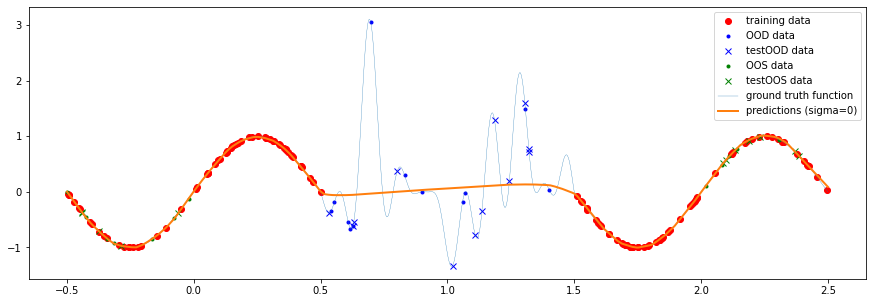

In [440]:
plt.figure(figsize=(15, 5))
plt.plot(x, y.squeeze(), 'ro', label='training data')
plt.plot(ood_x, ood_y.squeeze(), 'b.', label='OOD data')
plt.plot(ood_x_test, ood_y_test.squeeze(), 'bx', label='testOOD data')
plt.plot(oos_x, oos_y.squeeze(), 'g.', label='OOS data')
plt.plot(oos_x_test, oos_y_test.squeeze(), 'gx', label='testOOS data')
plt.plot(x_test, y_test.squeeze(), label='ground truth function', linewidth=.3)
plt.plot(x_test, model(x_test
                       , sigma=0., fixed_noise=True,
                      ).detach(), linewidth=2., label='predictions (sigma=0)')
# plt.plot(x_test, torch.stack([model.sample(x_test, fixed_noise=True).detach().squeeze() for _ in range(15)], 0).mean(0),
#          label='average samples (sigma=1)')
        
plt.legend()


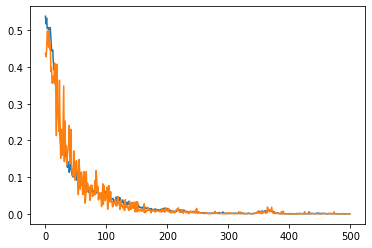

In [441]:
plt.plot(trainer.train_losses)
plt.plot(trainer.valid_losses)

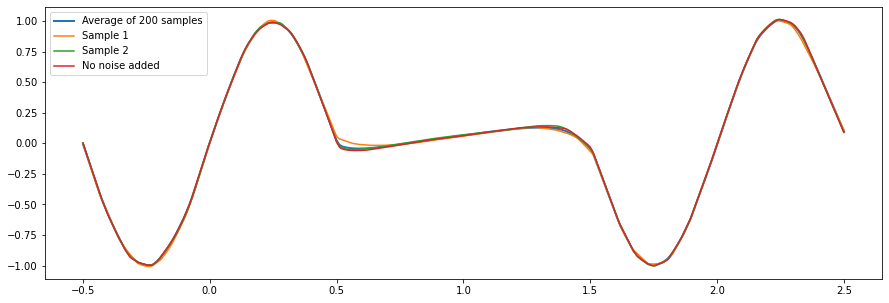

In [443]:
plt.figure(figsize=(15, 5))
samples = torch.stack([model.sample(x_test, fixed_noise=True).detach().squeeze() for _ in range(200)], 0)
plt.plot(x_test, samples.mean(0), linewidth=2., label='Average of 200 samples')
plt.plot(x_test, samples[0, :], label='Sample 1')
plt.plot(x_test, samples[1, :], label='Sample 2')
plt.plot(x_test, model(x_test, sigma=0.).detach(), label='No noise added')
plt.legend()
plt.show()
